In [1]:
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt

# Definition of data

In [2]:
generation_costs = np.array([15, 20, 15, 20, 30, 25.])
startup_costs = np.array([75, 100, 75, 100, 100, 125.])
shutdown_costs = np.array([7.5, 10.0, 7.5, 10.0, 10.0, 12.5])
running_costs = np.array([10, 5, 10, 10, 10, 10.])

capacity = np.array([10, 5, 10, 10, 20, 30.])
ramp_up_rate = np.array([2, 5, 2, 5, 10, 5.])
ramp_down_rate = np.array([2, 5, 2, 5, 10, 5.])

initial_state = np.array([1, 0,0, 0, 0, 0])

In [3]:
rt = np.array([15.2, 16.4, 16.1, 10.9, 14.8, 7.6, 15.6, 5.5, 9.2, 5.7, 1.5, 12.4, 10.4, 4.8, 14.3, 0.5, 6.6, 5.7, 11.5, 11.9, 2.8, 7.3, 6.7, 9.7])
dt = np.array([21.3, 21.4, 17.8, 20.9, 15.5, 17.6, 20.2, 23.8, 27.7, 30.1, 35.4, 39.4, 43.2, 47.0, 49.3, 51.5, 52.6, 50.3, 47.0, 43.1, 38.8, 33.2, 28.6, 24.3])

# Plotting Functions

In [4]:
def plot_analysis(rt, git, dt, generation_costs):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.fill_between(list(range(1,25)), 0, rt, label='Renewables')
    for i in range(6):
        plt.fill_between(list(range(1,25)), rt+git[:i,:].sum(axis=0), rt+git[:i+1,:].sum(axis=0), label=f'Generator {i+1}')
    plt.plot(list(range(1,25)),dt, color='black', label='Demand')
    plt.legend(loc='upper left')
    plt.title('Total Production')
    plt.subplot(1,3,2)
    for i in range(6):
        plt.plot(list(range(1,25)), git[i,:], label=f'Generator {i+1}', color=f'C{i+1}')
    plt.legend(loc='upper left')
    plt.title('Individual Production')
    plt.subplot(1,3,3)
    for i in range(6):
        plt.bar([i], [generation_costs[i]], label=f'Generator {i}', color=f'C{i+1}')
    plt.legend(loc='lower right')
    plt.title('Generation Cost');

def plot_generators(x_opt):
    plt.figure(figsize=(8,8))
    for i in range(6):
        plt.subplot(6,1,i+1)
        plt.bar(list(range(1,25)), x_opt[i].astype(int),color=f'C{i+1}')
        if i <5:
            plt.xticks([])
        plt.yticks([0,1])
        plt.ylabel(f'Generator {i+1}')

# Question 2.2

In [5]:
Tup = 3
Tdown = 2

In [6]:
g = cp.Variable((6,24))
u = cp.Variable((6,23), boolean=True)
v = cp.Variable((6,23), boolean=True)
x = cp.Variable((6,24), boolean=True)
objective = cp.Minimize(cp.sum(g.T @ generation_costs)
                       + cp.sum(u.T @ startup_costs)
                       + cp.sum(v.T @ shutdown_costs)
                       + cp.sum(x.T @ running_costs)
)
constraints = [
    dt == rt + cp.sum(g, axis=0),
    g>=0,
    g<=cp.multiply(x, capacity.reshape((-1,1))),
    x[:, :-1] - x[:, 1:] + u >=0,
    x[:, 1:] - x[:, :-1] + v >=0,   
] + [
    x[:,t] - x[:,t-1] <= x[:,tau]
    for t in range(1, 24)
    for tau in range(t+1, min(t+Tup, 24)) 
] + [
    x[:,t-1] - x[:,t] <= 1 - x[:,tau] 
    for t in range(1, 24)
    for tau in range(t+1, min(t+Tup, 24)) 
] + [
    x[:,0] == initial_state
]

problem = cp.Problem(objective, constraints)
problem.solve(solver = cp.GLPK_MI, verbose=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 13 12:41:54 PM: Your problem has 564 variables, 92 constraints, and 0 parameters.
(CVXPY) Apr 13 12:41:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 13 12:41:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 13 12:41:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 13 12:41:54 PM: Compiling problem (target solver=GLPK_MI).
(CVXPY) Apr 13 12:41:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

11024.5

In [7]:
print(f'The objective Value is {round(objective.value,2)}')

The objective Value is 11024.5


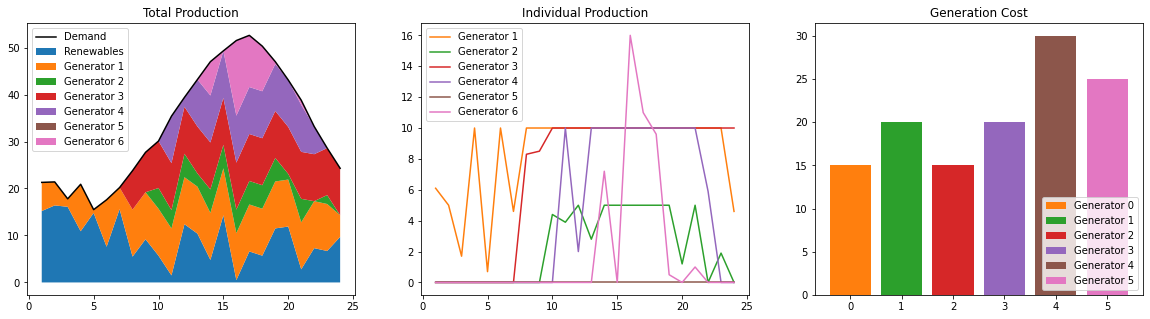

In [8]:
plot_analysis(rt, g.value, dt, generation_costs)

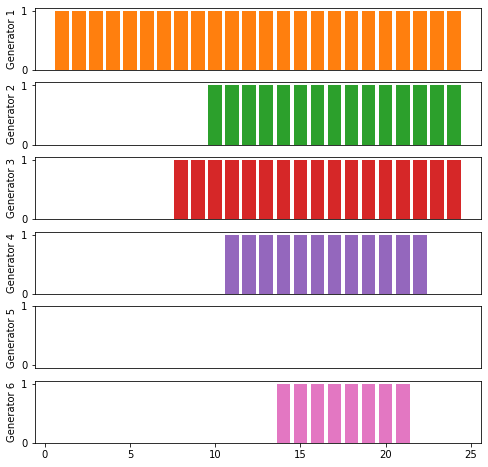

In [9]:
plot_generators(x.value)

# Question 2.3 Relaxed

In [10]:
Tup = 3
Tdown = 2

In [11]:
g = cp.Variable((6,24))
u = cp.Variable((6,23))
v = cp.Variable((6,23))
x = cp.Variable((6,24), boolean=True)
objective = cp.Minimize(cp.sum(g.T @ generation_costs)
                       + cp.sum(u.T @ startup_costs)
                       + cp.sum(v.T @ shutdown_costs)
                       + cp.sum(x.T @ running_costs)
)
constraints = [
    dt == rt + cp.sum(g, axis=0),
    g>=0,
    g<=cp.multiply(x, capacity.reshape((-1,1))),
    x[:, :-1] - x[:, 1:] + u >=0,
    x[:, 1:] - x[:, :-1] + v >=0,   
] + [
    x[:,t] - x[:,t-1] <= x[:,tau]
    for t in range(1, 24)
    for tau in range(t+1, min(t+Tup, 24)) 
] + [
    x[:,t-1] - x[:,t] <= 1 - x[:,tau] 
    for t in range(1, 24)
    for tau in range(t+1, min(t+Tup, 24)) 
] + [
    u>=0,
    u<=1,
    v>=0,
    v<=1
] + [
    x[:,0] == initial_state
]

problem = cp.Problem(objective, constraints)
problem.solve(solver = cp.GLPK_MI, verbose=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Apr 13 12:42:10 PM: Your problem has 564 variables, 96 constraints, and 0 parameters.
(CVXPY) Apr 13 12:42:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 13 12:42:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 13 12:42:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 13 12:42:10 PM: Compiling problem (target solver=GLPK_MI).
(CVXPY) Apr 13 12:42:10 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

11024.5

In [12]:
print(f'The objective Value is {round(objective.value,2)}')

The objective Value is 11024.5


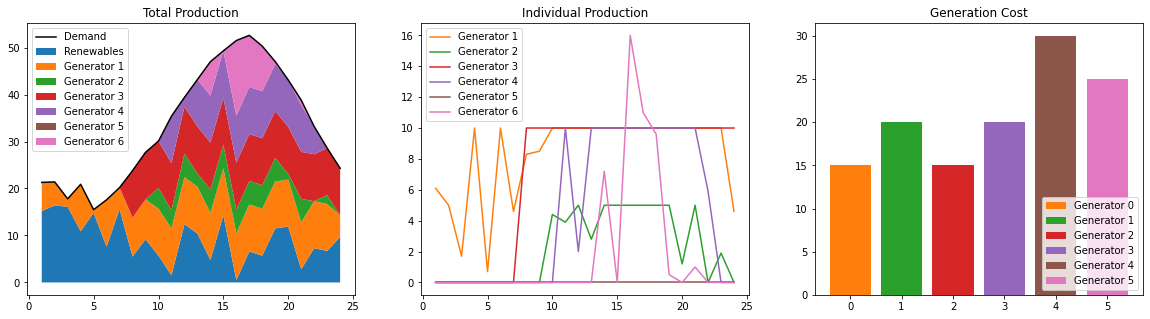

In [13]:
plot_analysis(rt, g.value, dt, generation_costs)

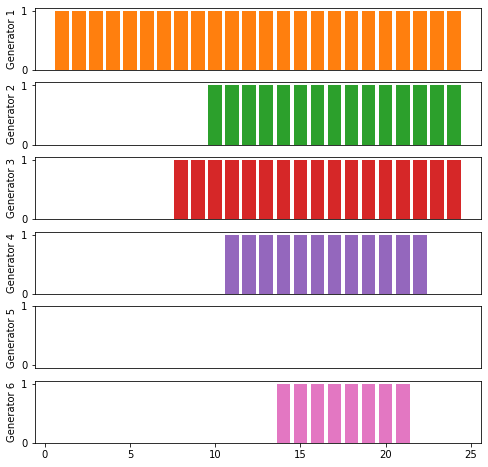

In [14]:
plot_generators(x.value)